# Homework 7

# Задача №1 - Можете ли вы отличить сорняки от рассады (v2)?

Усоврешенствуем подход решения задачи из домашней работы №6 следующим образом. На предыдущих парах мы проделали первые шаги в области машинного обучения: изучили понятия метрик, обучения, валидации, алгоритмы knn и линейных моделей. Закрепим все эти моменты на примере решения задачи мульти-классификации.

На занятиях мы отметили, что модели машинного обучения из некоторых признаков $X$ и меток к ним (зависимости) $y$ пытаемся восстановить такую функцию $f: f(X) = y$. Из предыдущих лекций по CV мы научились выделять признаки изобразений, то есть строить множество $X$. Теперь займемся построением функции $f$ с помощью методов машинного обучения.

Исходные изображения возьмите из соревнования на площадке [Kaggle](https://www.kaggle.com/c/plant-seedlings-classification/overview) 

Для нашего задания выделим только 4 класса:
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Small-flowered Cranesbill

Примеры изображений для теста:
<table><tr>
    <td> <img src="https://i.ibb.co/tbqR37m/fhj.png" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/6yL3Wmt/sfg.png" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/pvn7NvF/asd.png" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

Итоговое решение сделать по аналогии с sample_submission.csv, которое есть в исходных данных на площадке Kaggle. Ваше решение будет оцениваться  только на тех изображениях, которые действительно принадлежат к выделенным классам выше. Это уже забота проверяющего.

## В итоге вы должны предоставить ноутбук с решением и sample_submission.csv с ответом 

# Подготовка данных

Вопспользуйтесь наработками для решения домашней работы №5 и сгенерируйте вектор признаков для обучащей выборки и создайте набор признаков $X$. Если ваш алгоритм вычислительно сложный и долго формирует признаки, вы можете их сохранить и приложить к ответу (код с генерацией этих признаков также должен быть приложен в ноутбуке или отдельном файле). 

In [69]:
import numpy as np
import torch
import os
import cv2

from PIL import Image
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

TRAIN_DIR = Path('./../../../plants/train')
TEST_DIR = Path('./../../../plants/test')

train_files = sorted(list(TRAIN_DIR.rglob('*.png')))
test_files = sorted(list(TEST_DIR.rglob('*.png')))

classes = ['Maize', 'Scentless Mayweed', 'Small-flowered Cranesbill', 'Loose Silky-bent']
y_test = [3,3,0,0,3,3,3,2,0,3,0,0,3,2,1,2,1,2,3,2,1,1,2,0,2,1,1,0,2,2,3,1,3,3,0,1,2,1,0,0]

In [17]:
def get_characteristics(image, threshold=120):
    x = []
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    mask = np.zeros_like(gray)
    
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if image[i,j,1] - 8 >= image[i,j,0] and\
                np.all(image[i,j] < threshold):
                mask[i,j] = 255
            else:
                image[i,j,:] = 0
                
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((5,5),np.uint8)) 
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5,5),np.uint8)) 
    x = np.append(x, np.count_nonzero(mask)/image.shape[0]/image.shape[1])
    
    gray = cv2.bitwise_and(mask, gray)
    
    detector = cv2.xfeatures2d.SIFT_create(nfeatures=1000, nOctaveLayers=5, contrastThreshold=0.07, \
                                       edgeThreshold=10, sigma=1.3)

    keypoints = detector.detect(image, None)
    keypoints.sort(key=lambda x: x.size, reverse=True)
    
    contours, hierarchy = cv2.findContours(gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours.sort(key=len, reverse=True)
    
    if len(contours) < 3:
        if threshold >= 200:
            return np.zeros((11))
        x = get_characteristics(image, threshold + 20)
        return x
        
    for cont in contours[:3]:
        area = cv2.contourArea(cont)
        x = np.append(x, area/cv2.arcLength(cont, True))
        
    M = cv2.moments(contours[0])
    hu = cv2.HuMoments(M)
    x = np.append(x, hu)
    
    return x

In [47]:
x_train = np.zeros((len(train_files), 11))
y_train = np.zeros((len(train_files)))

for k, path in enumerate(train_files):
    image = Image.open(train_files[k])
    image.load()
    image = np.array(image)
    
    x_train[k] = get_characteristics(image)
    y_train[k] = classes.index(path.parent.name)

In [35]:
x_test = np.zeros((len(test_files), 11))

for k, path in enumerate(test_files):
    image = Image.open(test_files[k])
    image.load()
    image = np.array(image)
    
    x_test[k] = get_characteristics(image)

## Обзор сформированных характеристик

Так как алгоритм формирования характеристик изображений детерменирован, то полученные характеристки можно интепретировать. Постройте графики/гистограммы, как выделенные вами характеристки распределены у каждого класса в обучающей выборке.

Такая визуализация позволит вам анализировать - насколько ваши признаки позволяют решать поставленную задачу классификации.

# Стратегия валидации 


Итак, у вас есть данные для обучения и данные, на которых необходимо сделать предсказание. Для оценки точности необходимо проводить валидацию (так как мало данных, можно проводить кросс валидацию). Валидацию проще всего реализовать методами sklearn, например:
- KFold
- ShuffleSplit
- StratifiedKFold
- StratifiedShuffleSplit
- GroupKFold
- GroupShuffleSplit

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.5,random_state=42)

# Обучение алгоритма

## kNN

MSE is within 0.00 and 1.20 with an average 0.76


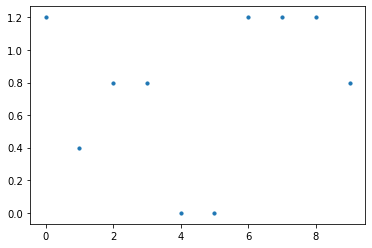

In [77]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score

MSE = []

for train_idx, test_idx in sss.split(x_train, y_train):
    X_train, X_val, Y_train, Y_val = x_train[train_idx], x_train[test_idx], y_train[train_idx], y_train[test_idx]
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, Y_train)
    
    knn_predictons = knn.predict(X_val).round()
    MSE = np.append(MSE, mean_squared_error(Y_val, knn_predictons))
    
plt.scatter(range(10), MSE, s=10)
plt.grid(True)
print("MSE is within %.2f and %.2f with an average %.2f" % (MSE.min(), MSE.max(), MSE.mean()))

## Линейные модели

MSE is within 4.90 and 621587.40 with an average 63273.93


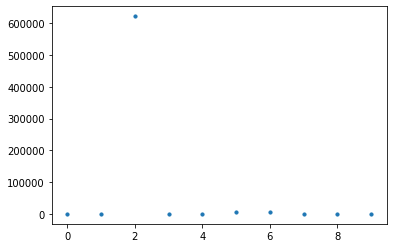

In [78]:
from sklearn.linear_model import LinearRegression

MSE = []

for train_idx, test_idx in sss.split(x_train, y_train):
    X_train, X_val, Y_train, Y_val = x_train[train_idx], x_train[test_idx], y_train[train_idx], y_train[test_idx]
    reg = LinearRegression().fit(X_train, Y_train)
    
    reg_predictons = reg.predict(X_val).round()
    MSE = np.append(MSE, mean_squared_error(Y_val, reg_predictons))
    
plt.scatter(range(10), MSE, s=10)
plt.grid(True)
print("MSE is within %.2f and %.2f with an average %.2f" % (MSE.min(), MSE.max(), MSE.mean()))

# Точность решения на отложенной выборке

Воспользуйтесь метриками для оценки точности мульти-классификации:
- F2
- confusion matrix

## F2

In [79]:
from sklearn.metrics import f1_score
y_pred = knn.predict(x_test).round()
f1_score(y_test, y_pred, average='micro')

0.85

## Confusion matrix

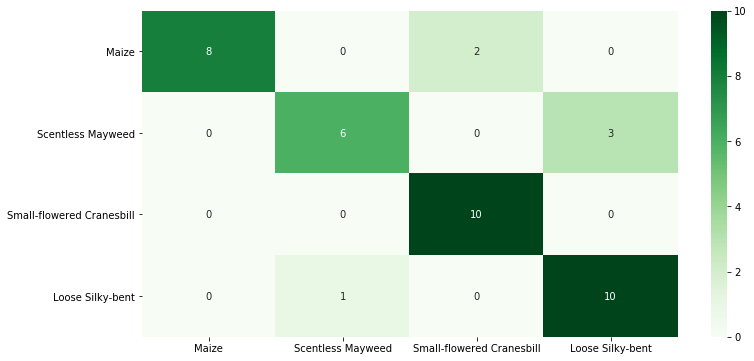

In [80]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusionmatrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 6))
sns.heatmap(confusionmatrix, cmap='Greens', annot=True,
            xticklabels=classes,
            yticklabels=classes)
plt.show()

# Финальное предсказание на тестовые данные 

Решением домашнего задания является данный ноутбук + .csv файл с предсказанием. Заполните его в соотвествии с примером sample_submission.csv

In [118]:
import pandas as pd

file_names = [os.path.basename(file) for file in test_files]
submission = pd.DataFrame(file_names, columns=['filename'])
submission['type'] = [classes[int(g)] for g in y_pred]
submission.to_csv('submission.csv', index=False)